In [1]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext

In [2]:
conf = SparkConf().setAppName("Application name")
sc = SparkContext(conf=conf)

## Difference between map and flatmap
- **`map`**: Transforms each element of a collection into a new collection, preserving the structure.
- **`flatMap`**: Transforms each element into a collection and then flattens the result into a single collection.

In [3]:
names = [
    "Mohammad Al-Hennawi",
    "Rafat Hammad",
    "Cristiano ronaldo"
]
# convert list to rdd
rdd1 = sc.parallelize(names)
rdd2 = sc.parallelize(names)

In [4]:
map_list = rdd1.map(lambda x: x.split()).collect() # 2D array
flatmap_list = rdd2.flatMap(lambda x: x.split()).collect() # 1D array

In [5]:
print('map', map_list)
print('flatMap', flatmap_list)

map [['Mohammad', 'Al-Hennawi'], ['Rafat', 'Hammad'], ['Cristiano', 'ronaldo']]
flatMap ['Mohammad', 'Al-Hennawi', 'Rafat', 'Hammad', 'Cristiano', 'ronaldo']


In [6]:
rdd1.saveAsTextFile('output')

### Output Folder:
![Output Folder](images/ss1.png) 

The number of parts is 12 because my PC has 12 threads, so it could be different from PC to another

### Word Count example

In [7]:
file = sc.textFile("data/input_01.txt", 4) # set the number of partitions
print(file) # lazy reading of the text file

data/input_01.txt MapPartitionsRDD[8] at textFile at NativeMethodAccessorImpl.java:0


In [8]:
lines = file.flatMap(lambda line: line.split())
print(lines) # lazy transformation

PythonRDD[9] at RDD at PythonRDD.scala:53


In [9]:
word = lines.map(lambda word: (word, 1))
print(word) # lazy transformation

PythonRDD[10] at RDD at PythonRDD.scala:53


In [10]:
counts = word.reduceByKey(lambda a, b: a + b)
print(counts) # lazy transformation

PythonRDD[15] at RDD at PythonRDD.scala:53


In [11]:
counts_list = counts.collect() # action
print(counts_list[:6])

# this cell takes most of the time because it starts the evaluation

[('================================================================================', 2), ('to', 18), ('Foundation', 2), ('(ASF)', 1), ('under', 5), ('more', 3)]


In [12]:
total_count = counts.map(lambda x: x[1]).reduce(lambda a, b: a + b) # reduce is the trigger here
print(total_count)

906


In [13]:
counts.saveAsTextFile('counts')

## Counts Folder:
![Counts Folder](images/ss2.png) 

The number of parts is four because I have set minPartitions to four

## Common Triggers (Actions) in PySpark

In PySpark, actions are operations that trigger the actual execution of the computations on the dataset. Below are some commonly used actions:

- **`collect()`**: Returns all the elements of the dataset as a list to the driver.
- **`count()`**: Returns the number of elements in the dataset.
- **`first()`**: Returns the first element of the dataset.
- **`take(n)`**: Returns the first `n` elements of the dataset.
- **`takeOrdered(n, key=None)`**: Returns the first `n` elements ordered by a specified key.
- **`reduce()`**: Aggregates the elements of the dataset using an associative function.
- **`foreach()`**: Applies a function to each element in the dataset, typically for side effects.
- **`saveAsTextFile(path)`**: Writes the dataset to a text file at the specified path.
- **`saveAsParquetFile(path)`**: Saves the dataset in Parquet format.
- **`countByKey()`**: Returns the count of elements with each key in the dataset.
- **`aggregate()`**: Aggregates the elements of the dataset with a combination of a zero value and an aggregate function.
- **`isEmpty()`**: Returns `True` if the dataset is empty.
- **`max()`**: Returns the maximum value in the dataset.
- **`min()`**: Returns the minimum value in the dataset.
- **`sum()`**: Returns the sum of all elements in the dataset.
- **`mean()`**: Returns the mean (average) value of the dataset.
- **`stdev()`**: Returns the standard deviation of the dataset.

These actions trigger the execution of transformations and return results to the driver program.

In [14]:
print(counts.count()) # prints number of distinct words

470


In [15]:
print(counts.takeOrdered(5, key=lambda x: -x[1])) # take the most 5 frequent words

[('the', 46), ('*', 30), ('to', 18), ('and', 18), ('in', 18)]


# Example of Lineage Graph: Count of Bad Lines in a Log File

A log file is a tracer of any action in a website or database. Fortunately, I have a website called **[PLogic](https://www.linkedin.com/posts/mohammad-al-hennawi-9856592b9_throughout-my-college-journey-in-data-activity-7253457852055379968-j0qz?utm_source=share&utm_medium=member_desktop)**, and it generates real log files. Below is a simple lineage graph:

# DAG:

<img src="images/DAG.png" alt="DAG">

# My Website Logs:

<img src="images/ss3_1.png" alt="LOGS">

In [16]:
log_file = sc.textFile("data/PlogicLogs.txt")

In [17]:
log_lower = log_file.map(lambda line: line.lower()) # covert all letters to lower case

In [18]:
# find if 'error' in the line (bad line) else returns -1 (good line)
error_rdd = log_lower.filter(lambda line: line.find("error") != -1)
 # find if 'waring' in the line (bad line) else returns -1 (good line)
waring_rdd = log_lower.filter(lambda line: line.find("warning") != -1)
# combine two RDDs into one
bad_rdd = waring_rdd.union(error_rdd)

In [19]:
print(bad_rdd.count())

5


In [20]:
print(bad_rdd.take(3))

['2024-11-28 12:46:10,443 - warning - deprecated operation \'&\' used in expression "a & b". consider replacing with \'&&\'.', '2024-11-28 12:49:45,603 - warning - unsupported operation "xor" in expression "a xor b". consider replacing with "^".', '2024-11-28 12:47:32,122 - error - syntaxerror in evaluate_expression: unexpected end of input (sample request: {"expression": "(a &"}). expected: complete logical expression like "(a & b)".']


In [23]:
# sorting bad lines by time, because each line starts with a date
print(*bad_rdd.sortBy(lambda x: x[0]).collect(), sep="\n")

2024-11-28 12:46:10,443 - warning - deprecated operation '&' used in expression "a & b". consider replacing with '&&'.
2024-11-28 12:49:45,603 - warning - unsupported operation "xor" in expression "a xor b". consider replacing with "^".
2024-11-28 12:47:32,122 - error - syntaxerror in evaluate_expression: unexpected end of input (sample request: {"expression": "(a &"}). expected: complete logical expression like "(a & b)".
2024-11-28 12:49:45,605 - error - error in evaluate_expression: invalid operation 'xor' (sample request: {"expression": "a xor b"}).
2024-11-28 12:51:10,113 - error - syntaxerror in evaluate_expression: missing closing parenthesis ')' (sample request: {"expression": "a & (b | c"}).


# Set-Like Operations in Spark

Spark provides a variety of transformations that allow you to perform set-like operations on RDDs or DataFrames. These operations include `union`, `subtract`, `intersect`, `distinct`, and `cartesian`.

These methods take other RRD as an argument

# Set Operations:
<img src="images/so_1.png">

In [40]:
# I have set numSlices to 2, because 12 threads take too much time
a = sc.parallelize([1, 2, 3, 4, 4], 2)
b = sc.parallelize([3, 4, 5, 6], 2)

result = a.union(b)
print(result.collect())
# it can have duplicates

[1, 2, 3, 4, 4, 3, 4, 5, 6]


In [41]:
result = a.intersection(b)
print(result.collect())

[4, 3]


In [42]:
result = a.subtract(b)
print(result.collect())

[1, 2]


In [43]:
a = sc.parallelize(['a', 'b'])
b = sc.parallelize([1, 2])

result = a.cartesian(b)
print(result.collect())

[('a', 1), ('a', 2), ('b', 1), ('b', 2)]


# Method Chaining in Spark

**Method chaining** is a common programming pattern used in Spark (and many other frameworks) where multiple operations or transformations are called sequentially on an object, making the code more concise and readable.

In Spark, method chaining allows you to perform multiple transformations or actions on an RDD or DataFrame in a single statement.

---

## Benefits of Method Chaining

1. **Conciseness**: Reduces the amount of code by chaining multiple operations in one line.
2. **Readability**: Makes the code flow like a pipeline, showcasing the transformations in order.
3. **Efficiency**: Helps in maintaining the immutability of RDDs or DataFrames and reduces intermediate variables.

In [54]:
a = sc.parallelize([1, 2, 3, 4, 4], 2)
b = sc.parallelize([3, 4, 5, 6], 2)

most_common_element = a.union(b)\
    .map(lambda num: (num, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .max(lambda x: x[1])

print(most_common_element)

(4, 3)


# Solving the Nearest Point (POI) in Spark:
Using method chaining

In [58]:
from math import sqrt

hospitals_locations = [
    (15, 10),(-5, 12),(22, -4),(10, -1), (18, 21),
    (-8, -10),(30, 3),(5, 17),(13, 14),(16, -7),
    (1, 11),(20, -5),(6, 8),(-2, 19),(24, 22),
    (9, 0),(7, 6),(11, 15),(19, 13),(-3, 16),
]
user_location = 9, 18

euclidean_distance = lambda point: sqrt((point[0] - user_location[0]) ** 2 + (point[1] - user_location[1]) ** 2)

In [72]:
nearest_hospital = sc.parallelize(hospitals_locations)\
    .zipWithIndex()\
    .map(lambda x: (euclidean_distance(x[0]), x[1]))\
    .min(lambda x: x[0])

print(nearest_hospital)

(3.605551275463989, 17)


In [74]:
# zipWithIndex example
rdd = sc.parallelize(['a', 'b', 'm', 'h'], 1)
print(rdd.zipWithIndex().collect())

[('a', 0), ('b', 1), ('m', 2), ('h', 3)]


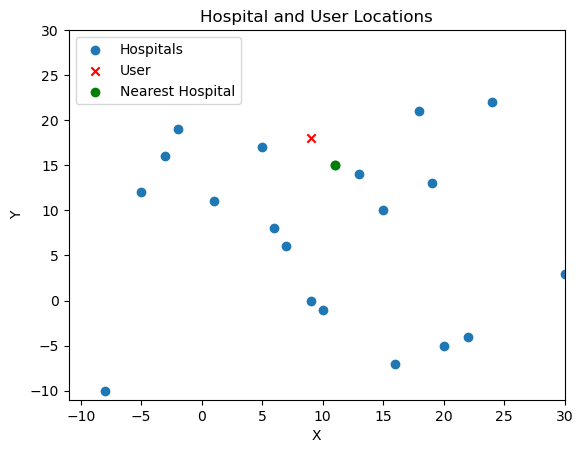

In [73]:
import matplotlib.pyplot as plt

plt.scatter(*zip(*hospitals_locations), label='Hospitals')
plt.scatter(*user_location, label='User', color='red', marker='x')
plt.scatter(*hospitals_locations[nearest_hospital[1]], label='Nearest Hospital', color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-11, 30)
plt.ylim(-11, 30)
plt.title('Hospital and User Locations')
plt.legend()
plt.show()